# Polars groupby on parquet data 2021+, eager vs lazy

In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

%load_ext autoreload
%autoreload 2

display(f"Pandas {pd.__version__}, Polars {pl.__version__}")

from cell_profiler import cell_profiler as cp
%start_cell_profiler

def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = 'Unknown'
    try:
        num_bytes = df.estimated_size() # try Polars
        df_type = 'Polars'
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum() # try Pandas
        df_type = 'Pandas'
    except AttributeError:
        pass
    display(f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes")

'Pandas 2.0.1, Polars 0.17.10'

In [1] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 209.2 MiB


In [62]:
dfple = pl.read_parquet('../test_result_2021on.parquet')

In [62] used 6601.5 MiB RAM in 10.70s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 33280.6 MiB


In [3]:
dfple.lazy().groupby(by='make').agg('cylinder_capacity')

In [3] used 0.2 MiB RAM in 0.12s (system mean cpu 9%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 12988.3 MiB


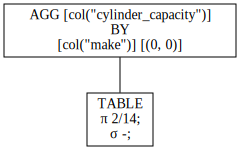

In [4] used 1.0 MiB RAM in 0.15s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 12989.2 MiB


In [4]:
dfple.lazy().groupby(by='make').agg('cylinder_capacity').show_graph()

In [21]:
%%time
result = dfple.filter(pl.col('cylinder_capacity').is_not_null()) \
.groupby(by='make').agg([pl.col('cylinder_capacity').median().alias('median'), pl.col('cylinder_capacity').count().alias('count')])\
.filter(pl.col('count') > 10).sort(by='median')
result[:3]

CPU times: user 24.6 s, sys: 47.4 s, total: 1min 11s
Wall time: 24.1 s


make,median,count
str,f64,u32
"""TESLA""",0.0,16
"""VECTRIX""",4.0,13
"""BEELINE""",49.0,304


In [21] used 8192.1 MiB RAM in 24.26s (system mean cpu 27%, single max cpu 100%), peaked 21424.3 MiB above final usage, current RAM usage now 16528.9 MiB


In [23]:
%%time
result = dfple.lazy().filter(pl.col('cylinder_capacity').is_not_null()) \
.groupby(by='make').agg([pl.col('cylinder_capacity').median().alias('median'), pl.col('cylinder_capacity').count().alias('count')])\
.filter(pl.col('count') > 10).sort(by='median').collect()
# note collect(streaming=True) same result
result[:3]

CPU times: user 19.9 s, sys: 5.85 s, total: 25.8 s
Wall time: 3.04 s


make,median,count
str,f64,u32
"""TESLA""",0.0,16
"""VECTRIX""",4.0,13
"""LINTEX HT50QT-…",49.0,15


In [23] used -96.2 MiB RAM in 3.15s (system mean cpu 54%, single max cpu 100%), peaked 3911.6 MiB above final usage, current RAM usage now 13457.2 MiB


In [7]:
result.filter(pl.col('make') == 'ROLLS ROYCE')

make,cyl_size,cyl_med
str,u32,f64
"""ROLLS ROYCE""",11741,6749.0


In [7] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 30%), peaked 0.0 MiB above final usage, current RAM usage now 14191.0 MiB


In [20]:
assert result.filter(pl.col('make') == 'ROLLS ROYCE')['cyl_med'].item() == 6749.0
assert result.filter(pl.col('make') == 'ROLLS ROYCE')['cyl_size'].item() == 11741.0

In [20] used 0.3 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 9%), peaked 0.0 MiB above final usage, current RAM usage now 8336.8 MiB


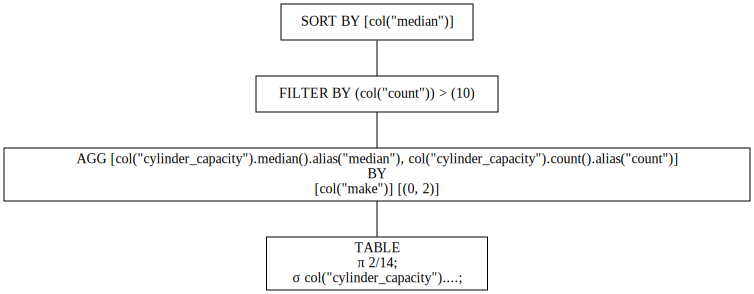

In [24] used 0.7 MiB RAM in 0.15s (system mean cpu 3%, single max cpu 7%), peaked 0.0 MiB above final usage, current RAM usage now 13457.9 MiB


In [24]:
# figsize in show_graph
dfple.lazy().filter(pl.col('cylinder_capacity').is_not_null()) \
.groupby(by='make').agg([pl.col('cylinder_capacity').median().alias('median'), pl.col('cylinder_capacity').count().alias('count')])\
.filter(pl.col('count') > 10).sort(by='median').show_graph()

# Resample

In [26]:
dfple.head()

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[ns],i64,str,str,i64,str,str,str,str,str,i64,datetime[ns]
334683447,634775234,2022-01-01 00:00:00,4,"""NT""","""P""",227219,"""E""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1497,2008-01-17 00:00:00
586095521,1220215709,2022-01-01 00:00:00,4,"""NT""","""P""",136552,"""CR""","""TOYOTA""","""PRIUS""","""GREY""","""Hybrid Electri…",1798,2013-11-29 00:00:00
960974211,1315791989,2022-01-01 00:00:00,4,"""NT""","""F""",129847,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00
1041792341,1144451355,2022-01-01 00:00:00,4,"""NT""","""P""",123133,"""TW""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1496,2016-11-21 00:00:00
1587264975,1315791989,2022-01-01 00:00:00,4,"""RT""","""P""",129848,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00


In [26] used -1.1 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 13440.6 MiB


In [66]:
dfple = pl.read_parquet('../test_result_2021on.parquet')

In [66] used 1926.5 MiB RAM in 9.65s (system mean cpu 19%, single max cpu 21%), peaked 0.0 MiB above final usage, current RAM usage now 34982.7 MiB


In [70]:
df = dfple.sample(10000)

In [70] used -10.8 MiB RAM in 0.91s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 34825.6 MiB


In [71]:
df.head(5)

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[ns],i64,str,str,i64,str,str,str,str,str,i64,datetime[ns]
1505464389,35593136,2022-07-27 00:00:00,4,"""NT""","""F""",93234,"""CB""","""MAZDA""","""3""","""BLUE""","""DI""",1998,2009-09-01 00:00:00
1685976335,1467967426,2022-02-04 00:00:00,4,"""NT""","""F""",141756,"""RG""","""PORSCHE""","""911""","""SILVER""","""PE""",3600,2004-02-07 00:00:00
186361931,115794780,2021-12-07 00:00:00,4,"""RT""","""P""",110767,"""MK""","""NISSAN""","""MICRA""","""BLUE""","""PE""",1386,2004-01-30 00:00:00
694287791,1050672306,2022-09-13 00:00:00,4,"""NT""","""P""",33658,"""CF""","""FORD""","""FOCUS""","""SILVER""","""PE""",1596,2012-05-31 00:00:00
1528314065,568514497,2021-10-23 00:00:00,4,"""NT""","""P""",53178,"""SR""","""HYUNDAI""","""I10""","""WHITE""","""PE""",1248,2016-05-06 00:00:00


In [71] used 0.0 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 34825.7 MiB


In [79]:
#dfple = dfple.with_columns(pl.col('test_date').dt.year().alias('test_year'))
dfple = dfple.with_columns( (pl.col('test_result')==pl.lit('P')).alias('passed'))
#dfple.sample(10000).with_columns((pl.col('cylinder_capacity')>1000).alias('other'))

In [79] used 10.7 MiB RAM in 0.65s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 34840.1 MiB


In [47]:
dfple.head(10000).sort(pl.col('test_date')).groupby_dynamic('test_date', every='1w').agg(pl.col('test_type')).mean()

test_date,test_type
datetime[ns],list[str]
null,null


In [47] used -66.5 MiB RAM in 0.14s (system mean cpu 5%, single max cpu 15%), peaked 64.2 MiB above final usage, current RAM usage now 14228.6 MiB


In [83]:
result = dfple.sort(pl.col('test_date')).groupby_dynamic('test_date', every='1w').agg(pl.col('passed').sum())

In [83] used -66.6 MiB RAM in 9.49s (system mean cpu 48%, single max cpu 100%), peaked 24672.1 MiB above final usage, current RAM usage now 24338.8 MiB


In [84]:
result.sample(5)

test_date,passed
datetime[ns],u32
2022-03-12 00:00:00,765983
2021-06-12 00:00:00,534035
2021-11-13 00:00:00,689559
2022-01-01 00:00:00,487268
2022-04-16 00:00:00,374312


In [84] used 0.0 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 24338.8 MiB


Text(2021-03-26 00:00:00, 200000, 'Lockdown effect 2020?')

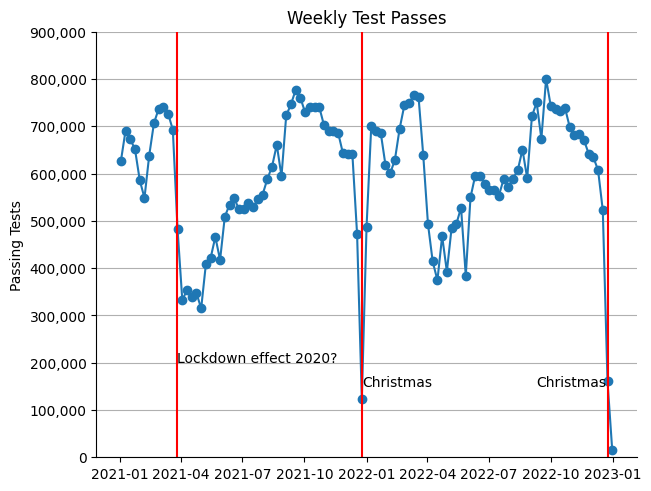

In [127] used 2.3 MiB RAM in 0.27s (system mean cpu 9%, single max cpu 60%), peaked 0.0 MiB above final usage, current RAM usage now 24584.8 MiB


In [127]:
from simpler_mpl import set_common_mpl_styles, set_commas
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(result['test_date'], result['passed'], marker='o')
set_common_mpl_styles(ax, title='Weekly Test Passes', ymin=0, ylabel="Passing Tests")#, xlabel="Weekly 2021-2022")
set_commas(ax, y_axis=True)
ax.axvline(pd.to_datetime('2021-12-25'), color='red')
ax.annotate('Christmas', (pd.to_datetime('2021-12-25'), 150000))
ax.axvline(pd.to_datetime('2022-12-25'), color='red')
ax.annotate('Christmas', (pd.to_datetime('2022-09-10'), 150000)) # horrid offset for alignment
ax.axvline(pd.to_datetime('2021-03-26'), color='red')
ax.annotate('Lockdown effect 2020?', (pd.to_datetime('2021-03-26'), 200000))

In [91]:
ax.plot

<bound method Axes.plot of <AxesSubplot: >>

In [91] used 16.4 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 24513.1 MiB
